# Simple neural network


In this notebook, we are going to create and train a simple neural network on the digits dataset using pytorch.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

First, we need to load the data and make them into pytorch tensors.

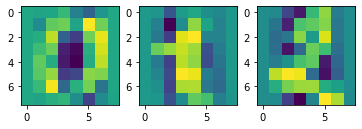

In [2]:
X, y = load_digits(return_X_y=True)

# Normalize

X -= X.mean(axis=0)
X /= np.std(X)
X_train, X_test, y_train, y_test = train_test_split(X, y)

f, axes = plt.subplots(1, 3)
for i, axe in enumerate(axes):
    axe.imshow(X[i].reshape(8, 8))

x = torch.tensor(X_train).float()
y = torch.tensor(y_train).long()
n, p = x.shape
x_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).long()

# Define the network

We will work with a simple network with two layers (one hidden layer).

The input $x$ is transformed into the output $z$ by the following operations:

$$y = \tanh(W_1x + b_1)$$
$$z = W_2y + b_2$$

**Exercise 1**: Define a function `net(x, W1, b1, W2, b2)` that implements this transform. Remember that `x` is a matrix of size $n\times p$

In [3]:
def net(x, W1, b1, W2, b2):
    y = torch.mm(x, W1.t()) + b1
    y = torch.tanh(y)
    z =  torch.mm(y, W2.t()) + b2
    return z

Next, let us specify the parameters of the network, `W1, b1, W2, b2`. You can chose the size of the hidden layer, but the input and output sizes are determined by the problem.

**Exercise 2**: Define a set of parameters `W1, b1, W2, b2`, where you chose the size of the hidden layer. Make sure that all these parameters have their `requires_grad` flag set to true, so that we can compute the gradient with respect to them.

In order to check that eveything works, compute `net(x, W1, b1, W2, b2)`.

In [4]:
hidden_size = 20
input_size = 64
output_size = 10

W1 = torch.randn(hidden_size, input_size)
b1 = torch.randn(hidden_size)
W2 = torch.randn(output_size, hidden_size)
b2 = torch.randn(output_size)

parameters = (W1, b1, W2, b2)

output = net(x, W1, b1, W2, b2)

Next, we will define a cost function. We will use the classical cross entropy loss. It is imported from pytorch in the next cell.

In [5]:
from torch.nn.functional import cross_entropy

In order to compute the gradient with respect to the parameters $W_1, W_2, b_1, b_2$, we will tell pytorch that we need to accumulate gradients by settings their `requires_grad` to `True`:

In [6]:
for parameter in parameters:
    parameter.requires_grad = True

**Exercise 3**: Compute the current loss of the network, and then back-propagate to compute the gradient with respect to the parameters. Check the gradient with respect to W1.

In [7]:
output = net(x, W1, b1, W2, b2)
loss = cross_entropy(output, y)
print(loss.item())
loss.backward()
print(W1.grad)

8.224804878234863
tensor([[ 0.0000,  0.0067,  0.0400,  ..., -0.0020,  0.0289,  0.0121],
        [ 0.0000,  0.0095,  0.0866,  ...,  0.0346,  0.0372,  0.0115],
        [ 0.0000, -0.0010,  0.0069,  ..., -0.0146, -0.0225, -0.0061],
        ...,
        [ 0.0000, -0.0008, -0.0064,  ..., -0.0344, -0.0089, -0.0003],
        [ 0.0000,  0.0011,  0.0177,  ...,  0.0147, -0.0167, -0.0071],
        [ 0.0000,  0.0046,  0.0131,  ..., -0.0104, -0.0080, -0.0039]])


We are almost ready to train our network!

But first, we will need to compute the accuracy of the network, on the train and test set.

**Exercise 4**: Define a function `accuracy(X, y, W1, b1, W2, b2)` that computes the accuracy of the network on the dataset `x`with true labels `y`. Remember that the predicted class at the output of the network is computed as the argmaximum of the output. Compute the current accuracy of the network on the train set. Is it normal ?

In [8]:
def accuracy(X, y, W1, b1, W2, b2):
    output = net(X, W1, b1, W2, b2)
    pred = output.argmax(axis=1)
    return (pred == y).sum().item() / len(y)


accuracy(x, y, W1, b1, W2, b2)

0.0935412026726058

# Training the network

We are now ready to train the network, using back-propagation and stochastic gradient descent.
First, we define the number of iterations of the algorithm, the step size, and the batch size. We also reinitialize the weights. Finally, we will store the train and test accuracy during the training.

In [9]:
n_iter = 1000
step_size = 0.1
batch_size = 64


test_list = []
train_list = []

**Exercise 5**: Complete the following training list, so that each parameter is updated at each iteration.

Remember that at each iteration, you should:
* compute the output of the network with respect to the batch
* Compute the loss, and backpropagate
* Update each parameter with gradient descent
* Refresh the gradient of each parameter. To do so, you can do:

```
parameter.grad.data.zero_()
```

In [10]:
for i in range(n_iter):
    batch_idx = torch.randperm(n)[:batch_size]
    x_batch = x[batch_idx]
    y_batch = y[batch_idx]
    output = net(x_batch, W1, b1, W2, b2)
    loss = cross_entropy(output, y_batch)
    loss.backward()
    with torch.no_grad():
        for parameter in parameters:
            parameter -= step_size * parameter.grad
            parameter.grad.data.zero_()
    if i % 10 == 0:
        with torch.no_grad():
            train_acc = accuracy(x, y, W1, b1, W2, b2)
            test_acc = accuracy(x_test, y_test, W1, b1, W2, b2)
        test_list.append(test_acc)
        train_list.append(train_acc)
        print('Iteration {} Train loss: {:1.3f} Train acc: {:1.3f} Test acc {:1.3f}'.format(i, loss.item(), train_acc, test_acc))

Iteration 0 Train loss: 7.732 Train acc: 0.098 Test acc 0.109
Iteration 10 Train loss: 5.248 Train acc: 0.149 Test acc 0.147
Iteration 20 Train loss: 5.237 Train acc: 0.215 Test acc 0.211
Iteration 30 Train loss: 3.281 Train acc: 0.281 Test acc 0.282
Iteration 40 Train loss: 2.878 Train acc: 0.367 Test acc 0.340
Iteration 50 Train loss: 2.426 Train acc: 0.445 Test acc 0.400
Iteration 60 Train loss: 1.881 Train acc: 0.512 Test acc 0.442
Iteration 70 Train loss: 1.846 Train acc: 0.549 Test acc 0.473
Iteration 80 Train loss: 1.467 Train acc: 0.581 Test acc 0.518
Iteration 90 Train loss: 1.305 Train acc: 0.607 Test acc 0.544
Iteration 100 Train loss: 1.540 Train acc: 0.636 Test acc 0.573
Iteration 110 Train loss: 1.066 Train acc: 0.659 Test acc 0.589
Iteration 120 Train loss: 1.108 Train acc: 0.682 Test acc 0.607
Iteration 130 Train loss: 0.895 Train acc: 0.699 Test acc 0.618
Iteration 140 Train loss: 1.007 Train acc: 0.721 Test acc 0.640
Iteration 150 Train loss: 0.708 Train acc: 0.737 Te

**Exercise 6**: Display the learning curves. You can then play with the network and training parameters:
what happens when you change the learning rate, the number of hidden sizes, etc?

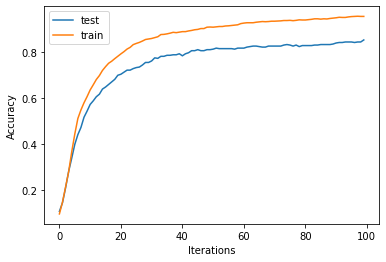

In [11]:
plt.plot(test_list, label='test')
plt.plot(train_list, label='train')

plt.ylabel('Accuracy')
plt.xlabel('Iterations')
plt.legend()